*italicized text*

# **End to End Japanes VS English Seq2Seq Translator**




In [ ]:
!pip install sacrebleu
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import sacrebleu
import json
import matplotlib.pyplot as plt
import csv
import json
import re


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.5 MB/s eta 0:00:00


In [ ]:
import json
import re

# Function to clean invalid escape sequences in JSON file
def clean_json(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    # Remove invalid \uXXXX sequences using regex
    content = re.sub(r'\\u[0-9A-Fa-f]{0,3}(?![0-9A-Fa-f])', '', content)
    return content

# Path to the JSON file
file_path = '/content/Japanes.json'

try:
    # Clean the JSON content
    cleaned_content = clean_json(file_path)
    # Parse the cleaned JSON content
    data = json.loads(cleaned_content)
    print("JSON loaded successfully.")

    # Extract sentences from the first 1000 entries
    en_sentences = [entry['input'] for entry in data[:1000]]
    ja_sentences = [entry['output'] for entry in data[:1000]]
    print(f"Loaded {len(en_sentences)} English and Japanes sentence pairs.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except KeyError as e:
    print(f"Key error: {e}")


JSON loaded successfully.
Loaded 1000 English and Japanes sentence pairs.


In [ ]:

# Hyperparameters
MAX_LEN = 60
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = 20000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
BATCH_SIZE = 32
NUM_EPOCHS = 10

tokenizer = lambda x: x.split()

# Build vocabulary
def build_vocab(sentences):
    counter = {}
    for sentence in sentences:
        for token in tokenizer(sentence):
            counter[token] = counter.get(token, 0) + 1
    return {word: idx + 4 for idx, (word, _) in enumerate(counter.items())}

en_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, **build_vocab(en_sentences)}
bu_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, **build_vocab(ja_sentences)}  # Lowercase 'ja_sentences'

# Convert sentences to tensors
def sentence_to_tensor(sentence, vocab, max_len=MAX_LEN):
    tokens = [vocab.get(word, vocab['<unk>']) for word in tokenizer(sentence)]
    return torch.tensor([vocab['<s>']] + tokens + [vocab['</s>']] + [vocab['<pad>']] * (max_len - len(tokens) - 2))[:max_len]

en_tensor_sentences = [sentence_to_tensor(s, en_vocab) for s in en_sentences]
ja_tensor_sentences = [sentence_to_tensor(s, bu_vocab) for s in ja_sentences]  # Lowercase 'bu_tensor_sentences'

# Split into training and validation sets
train_size = int(len(en_tensor_sentences) * 0.8)
train_en, val_en = en_tensor_sentences[:train_size], en_tensor_sentences[train_size:]
train_ja, val_ja = ja_tensor_sentences[:train_size], ja_tensor_sentences[train_size:]  # Lowercase 'train_bu' and 'val_bu'


In [ ]:
def print_sample_data(en_sentences, bu_sentences):
    for i in range(4):
        en_sample, bu_sample = en_sentences[i], bu_sentences[i]
        print(f"EN to JA\n<s>\n<en> {en_sample} </en>\n<ja> {bu_sample} </ja>\n</s>")
        print(f"JA to EN\n<s>\n<ja> {bu_sample} </ja>\n<en> {en_sample} </en>\n</s>\n")

# Call the function with English and Bulgarian sentences
print_sample_data(en_sentences, ja_sentences)


EN to JA
<s>
<en> Give three tips for staying healthy. </en>
<ja> 健康を維持するための3つのヒントを教えてください。 </ja>
</s>
JA to EN
<s>
<ja> 健康を維持するための3つのヒントを教えてください。 </ja>
<en> Give three tips for staying healthy. </en>
</s>

EN to JA
<s>
<en> 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night. </en>
<ja>  1. バランスの

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, en, ja):
        self.en, self.te = en, ja
    def __len__(self):
        return len(self.en)
    def __getitem__(self, idx):
        return self.en[idx], self.te[idx]

def collate_fn(batch):
    en_batch, te_batch = zip(*batch)
    return torch.stack(en_batch, dim=0), torch.stack(te_batch, dim=0)

train_loader = DataLoader(TranslationDataset(train_en, train_ja), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TranslationDataset(val_en, val_ja), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [ ]:
import pandas as pd

class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, embed_dim, hidden_dim, layers=1):
        super().__init__()
        self.encoder_embed = nn.Embedding(input_size, embed_dim)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, layers, batch_first=True)
        self.decoder_embed = nn.Embedding(output_size, embed_dim)
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, layers, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, output_size)

    def forward(self, src, tgt):
        _, (hidden, cell) = self.encoder_lstm(self.encoder_embed(src))
        output, _ = self.decoder_lstm(self.decoder_embed(tgt), (hidden, cell))
        return self.output_fc(output)

model = Seq2Seq(len(en_vocab), len(bu_vocab), EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)

def custom_model_summary(model):
    # Extract model details
    model_summary = []
    for name, param in model.named_parameters():
        layer_info = {
            "Layer Name": name,
            "Layer Type": type(param).__name__,
            "Output Shape": list(param.size()),
            "Parameters": param.numel()
        }
        model_summary.append(layer_info)

    # Display as a DataFrame table
    df_summary = pd.DataFrame(model_summary)
    print(df_summary.to_markdown(index=False))

custom_model_summary(model)

| Layer Name                | Layer Type   | Output Shape   |   Parameters |
|:--------------------------|:-------------|:---------------|-------------:|
| encoder_embed.weight      | Parameter    | [9979, 256]    |      2554624 |
| encoder_lstm.weight_ih_l0 | Parameter    | [2048, 256]    |       524288 |
| encoder_lstm.weight_hh_l0 | Parameter    | [2048, 512]    |      1048576 |
| encoder_lstm.bias_ih_l0   | Parameter    | [2048]         |         2048 |
| encoder_lstm.bias_hh_l0   | Parameter    | [2048]         |         2048 |
| decoder_embed.weight      | Parameter    | [3529, 256]    |       903424 |
| decoder_lstm.weight_ih_l0 | Parameter    | [2048, 256]    |       524288 |
| decoder_lstm.weight_hh_l0 | Parameter    | [2048, 512]    |      1048576 |
| decoder_lstm.bias_ih_l0   | Parameter    | [2048]         |         2048 |
| decoder_lstm.bias_hh_l0   | Parameter    | [2048]         |         2048 |
| output_fc.weight          | Parameter    | [3529, 512]    |      1806848 |

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=bu_vocab['<pad>'])
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for en_batch, te_batch in train_loader:
            en_batch, te_batch = en_batch.to(DEVICE), te_batch.to(DEVICE)
            te_batch = te_batch.long()
            optimizer.zero_grad()
            output = model(en_batch, te_batch)
            loss = criterion(output.reshape(-1, output.shape[-1]), te_batch.reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for en_batch, te_batch in val_loader:
                en_batch, te_batch = en_batch.to(DEVICE), te_batch.to(DEVICE)
                output = model(en_batch, te_batch)
                loss = criterion(output.reshape(-1, output.shape[-1]), te_batch.reshape(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=NUM_EPOCHS)

torch.save(model.state_dict(), 'seq2seq_translation_model.pth')

Epoch 1/10, Train Loss: 6.097465324401855, Val Loss: 5.092236825398037
Epoch 2/10, Train Loss: 4.661312370300293, Val Loss: 5.027219261441912
Epoch 3/10, Train Loss: 3.8705896663665773, Val Loss: 5.154848745891026
Epoch 4/10, Train Loss: 3.125432167053223, Val Loss: 5.302138430731637
Epoch 5/10, Train Loss: 2.388099613189697, Val Loss: 5.397833040782383
Epoch 6/10, Train Loss: 1.6955492973327637, Val Loss: 5.537376948765346
Epoch 7/10, Train Loss: 1.1266093611717225, Val Loss: 5.595311301095145
Epoch 8/10, Train Loss: 0.7355673837661744, Val Loss: 5.730415548597064
Epoch 9/10, Train Loss: 0.50670405626297, Val Loss: 5.77581650870187
Epoch 10/10, Train Loss: 0.3601678001880646, Val Loss: 5.809743676866804


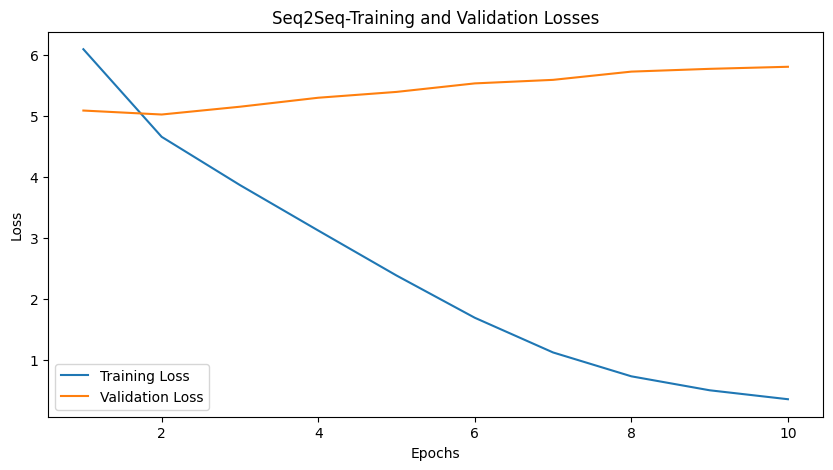

In [ ]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Seq2Seq-Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
def translate_new_sentence(model, input_sentence, input_vocab, output_vocab, max_len=MAX_LEN):
    """
    Translate a new sentence from input language to output language.
    """
    model.eval()
    input_tensor = sentence_to_tensor(input_sentence, input_vocab, max_len).unsqueeze(0).to(DEVICE)

    # Start with the <s> token as input to the decoder
    output_input = torch.tensor([output_vocab['<s>']]).unsqueeze(0).to(DEVICE)

    translated_tokens = []
    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, output_input)
            output_token = output.argmax(dim=-1)[:, -1].item()  # Get the most likely next token

            if output_token == output_vocab['</s>']:  # End token
                break

            translated_tokens.append(output_token)

            # Update the input for the next time step
            output_input = torch.cat([output_input, torch.tensor([[output_token]]).to(DEVICE)], dim=1)

    # Convert token IDs back to words
    translated_sentence = " ".join([k for k, v in output_vocab.items() if v in translated_tokens])

    # Wrap the output in the desired format
    return translated_sentence.strip()


def translate_and_format(model, input_sentence, input_vocab, output_vocab, direction, max_len=MAX_LEN):
    """
    Wrapper function to format the translation output.
    """
    translated_sentence = translate_new_sentence(model, input_sentence, input_vocab, output_vocab, max_len)
    return f"<s>\n<{direction[0]}> {input_sentence.strip()} </{direction[0]}>\n<{direction[1]}> {translated_sentence} </{direction[1]}>\n</s>"


# Test translation
en_example_sentence = "good morning my friend."
ja_example_sentence = "おはよう、友よ."

# English to Japanes
translated_ja_sentence = translate_and_format(model, en_example_sentence, en_vocab, bu_vocab, direction=("en", "ja"))
print(translated_ja_sentence)

# Japanes to English
translated_en_sentence = translate_and_format(model, ja_example_sentence, bu_vocab, en_vocab, direction=("ja", "en"))
print(translated_en_sentence)


<s>
<en> good morning my friend. </en>
<ja> ソフィーは机に座り、ぼんやりとコンピューターの画面を見つめていました。目の前の選択肢を検討しながら、彼女の心は高鳴っていました。彼女は社内で上級管理職への昇進をオファーされていましたが、それは友人や家族を置き去りにして国を越えて移動することを意味していました。同時に、彼女の夢だったライバル会社での仕事がついに決まり、面接に招待されました。快適な生活を離れ、何か新しい不確実なことに挑戦するという考えは、ソフィーを不安にさせましたが、同時に興奮させました。彼女は常にリスクを冒す性格であり、過去にはそれが報われました。しかし今、これほど大きな決断を下さなければならなくなり、ソフィーは圧倒されずにはいられませんでした。熟考の末、ソフィーは決断を下しました。彼女は荷物をまとめ、愛する人たちに別れを告げ、新しい仕事のために国中を移動しました。最初の数か月間は、新しい都市と新しい企業文化に適応するのに苦労しました。しかし、時間が経つにつれて、ソフィーは自分のキャリアにとって最善の決断を下したことに気づきました。その仕事はやりがいのあるものでしたが、同時にやりがいもあり、彼女は情熱的で意欲的な同僚たちに囲まれており、彼らは彼女の成長と発展にインスピレーションを与えてくれました。結局、ソフィーの大胆な行動が功を奏した。彼女は新しい役割で成功し、新しい街で新しい友達やつながりを作りました。振り返ってみると、ソフィーはリスクをとって変化を起こす機会に感謝し、自分のキャリアにとって正しい決断を下したと自信を持っていました。 マザーボードはメインボードまたはシステムボードとも呼ばれ、コンピュータの中心となるプリント回路基板です。これは、コンピューターのバックボーンまたは基盤として機能し、CPU、RAM、ストレージ 決意 生計の喪失: 照明を使用する: ドアや窓の周りにウェザーストリップを取り付けて空気漏れを防ぎ、冷暖房システムへの負荷を軽減します。 9 再生可能エネルギー利用の重要性 注文: 進数を等価な 私は今あなたにとても腹を立てています 彼/彼女は不安です。 新鮮な季節の地元産の農産物や製品を顧客の自宅に直接配達することで、地元の農家と消費者を結び付けます。 24. トリニダード・トバゴ プログラム

In [ ]:
def translate_new_sentence(model, sentence, src_vocab, tgt_vocab, max_len=50):
    model.eval()
    en_indices = [src_vocab.get(word, src_vocab['<unk>']) for word in sentence.split()]
    en_tensor = torch.tensor(en_indices).unsqueeze(0).to(DEVICE)
    tgt_tensor = torch.tensor([tgt_vocab['<s>']]).unsqueeze(0).to(DEVICE)
    translated_sentence = []

    for _ in range(max_len):
        with torch.no_grad():
            output = model(en_tensor, tgt_tensor)

        output_token = output.argmax(dim=-1)[:, -1]
        output_token_item = output_token.item()
        translated_word = list(tgt_vocab.keys())[list(tgt_vocab.values()).index(output_token_item)]
        translated_sentence.append(translated_word)

        if translated_word == '</s>':
            break

        tgt_tensor = torch.cat((tgt_tensor, output_token.unsqueeze(0)), dim=-1)

    return ' '.join(translated_sentence)

def calculate_bleu_chrf(en_sentences, te_sentences, model, en_vocab, te_vocab, max_len=50):
    bleu_scores, chrf_scores = [], []

    for en_sentence, ja_sentence in zip(en_sentences, ja_sentences):
        translated_sentence = translate_new_sentence(model, en_sentence, en_vocab, bu_vocab, max_len)

        # Calculate BLEU Score without smoothing
        bleu_score = sacrebleu.corpus_bleu([translated_sentence], [[ja_sentence]]).score
        bleu_scores.append(bleu_score)

        # Calculate CHRF Score without smoothing
        chrf_score = sacrebleu.corpus_chrf([translated_sentence], [[ja_sentence]]).score
        chrf_scores.append(chrf_score)

    return bleu_scores, chrf_scores

lstm_bleu_scores, lstm_chrf_scores = calculate_bleu_chrf(en_sentences, ja_sentences, model, en_vocab, bu_vocab)

# Save BLEU scores to CSV
with open('Seq2Seq_BLEU_scores11.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["BLEU Score"])  # Only BLEU score
    for bleu in lstm_bleu_scores:
        writer.writerow([bleu])  # Just the BLEU score

# Save CHRF scores to CSV
with open('Seq2Seq_CHRF_scores1.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["CHRF Score"])  # Only CHRF score
    for chrf in lstm_chrf_scores:
        writer.writerow([chrf])  # Just the CHRF score

print("BLEU and CHRF scores saved to CSV files.")

BLEU and CHRF scores saved to CSV files.


In [ ]:
import pandas as pd

# Load the CHRF scores from the CSV files
seq2seq_chrf_df = pd.read_csv('Seq2Seq_CHRF_scores1.csv')
lstm_chrf_df = pd.read_csv('Seq2Seq_lstm_CHRF_scores1.csv')

# Ensure both DataFrames have the same number of rows
min_rows = min(len(seq2seq_chrf_df), len(lstm_chrf_df))

# Trim the DataFrames to the smallest size if needed
seq2seq_chrf_df = seq2seq_chrf_df.iloc[:min_rows]
lstm_chrf_df = lstm_chrf_df.iloc[:min_rows]

# Combine the data into a single DataFrame
combined_chrf_df = pd.DataFrame({
    "Sentence Index": range(1, min_rows + 1),
    "Seq2Seq CHRF Score": seq2seq_chrf_df['CHRF Score'],
    "LSTM Seq2Seq CHRF Score": lstm_chrf_df['CHRF Score']
})

# Save the combined DataFrame to a new CSV file
combined_chrf_df.to_csv('Combined_CHRF_Scores.csv', index=False, encoding='utf-8')
print("Combined CHRF scores saved to 'Combined_CHRF_Scores.csv'.")

# Display the first few rows of the combined DataFrame
print(combined_chrf_df.head())

Combined CHRF scores saved to 'Combined_CHRF_Scores.csv'.
   Sentence Index  Seq2Seq CHRF Score  LSTM Seq2Seq CHRF Score
0               1                 0.0                      0.0
1               2                 0.0                      0.0
2               3                 0.0                      0.0
3               4                 0.0                      0.0
4               5                 0.0                      0.0


In [28]:
import pandas as pd

# Load the BLEU scores from the CSV files
seq2seq_bleu_df = pd.read_csv('Seq2Seq_BLEU_scores11.csv')
lstm_bleu_df = pd.read_csv('Seq2Seq_lstm_BLEU_scores.csv')

# Ensure both DataFrames have the same number of rows
min_rows = min(len(seq2seq_bleu_df), len(lstm_bleu_df))

# Trim the DataFrames to the smallest size if needed
seq2seq_bleu_df = seq2seq_bleu_df.iloc[:min_rows]
lstm_bleu_df = lstm_bleu_df.iloc[:min_rows]

# Combine the data into a single DataFrame
combined_bleu_df = pd.DataFrame({
    "Sentence Index": range(1, min_rows + 1),
    "Seq2Seq BLEU Score": seq2seq_bleu_df['BLEU Score'],
    "LSTM Seq2Seq BLEU Score": lstm_bleu_df['BLEU Score']
})

# Save the combined DataFrame to a new CSV file
combined_bleu_df.to_csv('Combined_BLEU_Scores.csv', index=False, encoding='utf-8')
print("Combined BLEU scores saved to 'Combined_BLEU_Scores.csv'.")

# Display the first few rows of the combined DataFrame
print(combined_bleu_df.head())


Combined BLEU scores saved to 'Combined_BLEU_Scores.csv'.
   Sentence Index  Seq2Seq BLEU Score  LSTM Seq2Seq BLEU Score
0               1            0.000000                      0.0
1               2            0.683769                      0.0
2               3            0.000000                      0.0
3               4            0.565776                      0.0
4               5            0.000000                      0.0


In [30]:
import pandas as pd

# Load the uploaded CSV file to check its content
file_path = 'Combined_BLEU_Scores.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


Sentence Index  Seq2Seq BLEU Score  LSTM Seq2Seq BLEU Score
0               1            0.000000                      0.0
1               2            0.683769                      0.0
2               3            0.000000                      0.0
3               4            0.565776                      0.0
4               5            0.000000                      0.0

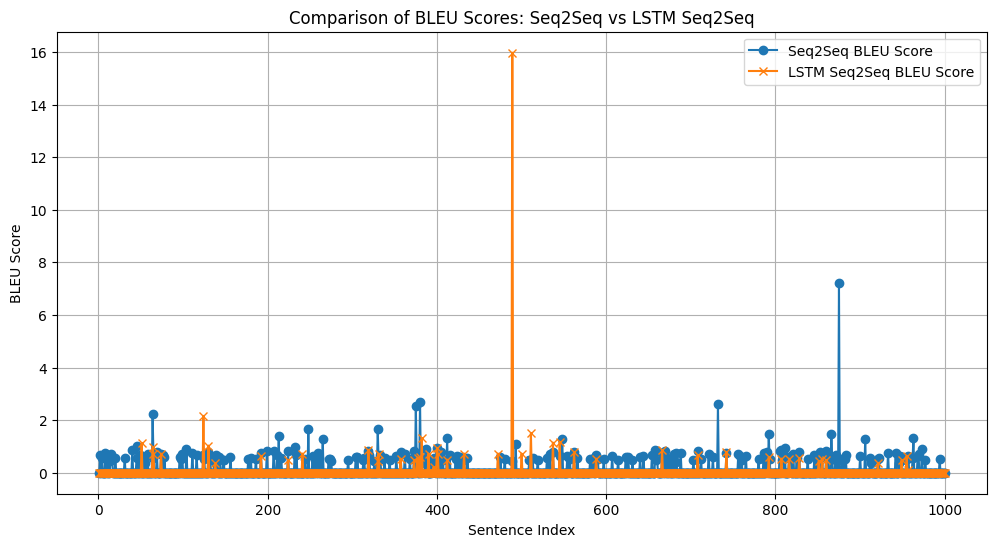

In [36]:
import matplotlib.pyplot as plt

# Plotting the BLEU scores for Seq2Seq and LSTM Seq2Seq models
plt.figure(figsize=(12, 6))
plt.plot(data['Sentence Index'], data['Seq2Seq BLEU Score'], label='Seq2Seq BLEU Score', marker='o')
plt.plot(data['Sentence Index'], data['LSTM Seq2Seq BLEU Score'], label='LSTM Seq2Seq BLEU Score', marker='x')

# Adding labels and title
plt.xlabel('Sentence Index')
plt.ylabel('BLEU Score')
plt.title('Comparison of BLEU Scores: Seq2Seq vs LSTM Seq2Seq')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Load the newly uploaded CSV file to check its content
file_path_chrf = 'Combined_CHRF_Scores.csv'
data_chrf = pd.read_csv(file_path_chrf)

# Display the first few rows of the dataset to understand its structure
data_chrf.head()


Sentence Index  Seq2Seq CHRF Score  LSTM Seq2Seq CHRF Score
0               1                 0.0                      0.0
1               2                 0.0                      0.0
2               3                 0.0                      0.0
3               4                 0.0                      0.0
4               5                 0.0                      0.0

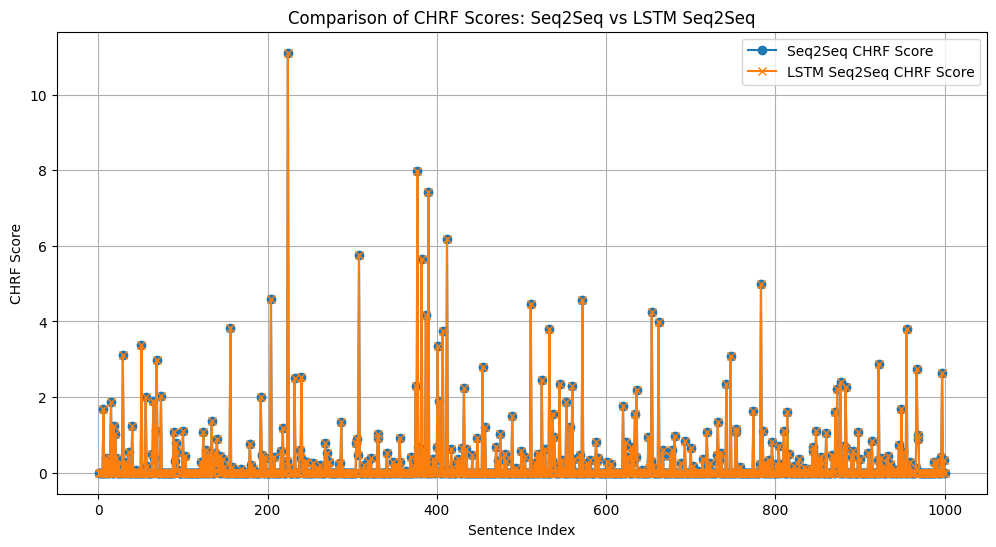

In [35]:
# Plotting the CHRF scores for Seq2Seq and LSTM Seq2Seq models
plt.figure(figsize=(12, 6))
plt.plot(data_chrf['Sentence Index'], data_chrf['Seq2Seq CHRF Score'], label='Seq2Seq CHRF Score', marker='o')
plt.plot(data_chrf['Sentence Index'], data_chrf['LSTM Seq2Seq CHRF Score'], label='LSTM Seq2Seq CHRF Score', marker='x')

# Adding labels and title
plt.xlabel('Sentence Index')
plt.ylabel('CHRF Score')
plt.title('Comparison of CHRF Scores: Seq2Seq vs LSTM Seq2Seq')
plt.legend()
plt.grid(True)
plt.show()
